KDAG task round 
problem 2
SOHAM AGARWAL
24CH10039

# ASKED CODE

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## functions defined

In [72]:
def boW(inp_column):
    unique_words = list(inp_column.unique())
    #creating a bow_array just like tf_matrix
    # unique_words = inp_column.unique()
    boW_array = np.zeros((len(inp_column), len(unique_words)))
    
    #to count the no of times a word from the unique word list is present in one row (1/0)
    for i, keywords in enumerate(inp_column):
        song_keywords=keywords.split()
        for word in song_keywords:
            if word in unique_words:
                boW_array[i, unique_words.index(word)]+=1 #getting the count it is repeated
    
    bow_df = pd.DataFrame(boW_array,columns=unique_words)
    return boW_array,bow_df

In [73]:
def tfidf_vectorize(inp_column):
    unique_words = list(inp_column.unique())
    
    # directly using bow instead of tf
    idf_matrix = np.zeros(len(unique_words))
    #calculating idf means in how many items that keyword has repeated among all the items
    for i, word in enumerate(unique_words):
        item_count = sum(1 for song_keywords in inp_column if word in song_keywords)
        # Calculate IDF
        idf_matrix[i] = np.log((1 + len(inp_column)) / (1 + item_count)) +1  
        # Earlier without using the +1 , the elements were becoming undefined 
        #so added +1 to avoid the undefined cases like log(0)/log(infinite)

    tfidf_array = boW(inp_column)[0]*idf_matrix
    norms = np.linalg.norm(tfidf_array, axis=1, keepdims=True)
    tfidf_array = tfidf_array / norms
    
    return tfidf_array

In [74]:
def standardize_data(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    standardized_data = (data - mean) /(std)
    return standardized_data


In [75]:
def pca_decomp(data):
    cov_array = np.cov(standardize_data(data), rowvar=False) #signifies the relation between how two keywords depend upon on each other
    eigenvectors = np.linalg.eig(cov_array)[1]

    df1 = pd.DataFrame(np.linalg.eig(cov_array)[0],columns = ['eigenvalues']) 
    df2 = pd.DataFrame(eigenvectors)
    df = pd.concat([df1,df2],axis=1)
    df.sort_values(by='eigenvalues',ascending=False,inplace=True)
    pca_result = np.dot(standardize_data(data), df.iloc[:,1:].to_numpy()[:, :2])
    return pca_result

In [76]:
k=5 #define the number of clusters
def kmeans(data, k= k, max_iterations=100):
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]

    for _ in range(max_iterations):
        distances = np.sqrt(((data - centroids[:, np.newaxis])**2).sum(axis=2))
        labels = np.argmin(distances, axis=0)
        new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])

        # If the centroids don't change
        if np.all(centroids == new_centroids):
            break
        # centroids = new_centroids
    return labels, new_centroids, centroids

In [77]:
def silhouette_score(data, labels):
    (rows,columns) = data.shape
    label = np.unique(labels)

    self_d = np.zeros(rows)
    
    other_d = np.zeros(rows)
    
    for i in range(rows):
        #finding distance with all the points in the same cluster
        cluster_label = labels[i]
        cluster_points = data[labels == cluster_label]
        self_d[i] = np.mean(np.linalg.norm(cluster_points - data[i], axis=1))
        
        other_d[i] = np.inf
        for other_label in label:
            #finding distance with all the points in the other cluster
            if other_label != cluster_label:
                points = data[labels == other_label]
                avg_dist = np.mean(np.linalg.norm(points- data[i], axis=1))
                if avg_dist < other_d[i]:
                    other_d[i] = avg_dist

    s = (other_d - self_d) / np.maximum(self_d , other_d)
    return np.mean(s)

## importing the data

In [78]:
data =pd.read_csv('TASK2_dataset.csv')    #importing the dataset into the machine
print(data.head())
print(data.shape)

   song_id keyword_1  keyword_2  keyword_3      genre
0       74    guitar      happy  distorted       rock
1      103     brass  energetic    melodic  classical
2      201     banjo      happy   acoustic    country
3      194     synth  energetic      heavy    hip-hop
4      184     synth  energetic       slow    hip-hop
(147, 5)


In [79]:
unique_kw1 = list(data['keyword_1'].unique())
unique_kw2 = list(data['keyword_2'].unique())
unique_kw3 = list(data['keyword_3'].unique())
unique_words = unique_kw1 + unique_kw2 + unique_kw3

## tf_idf vectorization & pca

In [80]:
tfidf_kw1= tfidf_vectorize(data['keyword_1'])
pca_1= pca_decomp(tfidf_kw1)

tfidf_kw2 = tfidf_vectorize(data['keyword_2'])
pca_2 = pca_decomp(tfidf_kw2)

tfidf_kw3= tfidf_vectorize(data['keyword_3'])
pca_3= pca_decomp(tfidf_kw3)

In [81]:
#creating the final array and its dataframe
tfidf_pca_array= np.cbrt(0.6*(pca_1**3)+0.2*(pca_2**3)+0.2*(pca_3**3))
k_tfidf_sep = pd.DataFrame(tfidf_pca_array,columns=["PC1","PC2"])
k_tfidf_sep

,PC1,PC2
0,0.777807,2.090152
1,-0.209755,0.092165
2,-0.608017,0.384740
3,0.357954,0.204393
4,0.207561,0.098906
...,...,...
142,-0.211577,-0.070257
143,0.228590,0.043702
144,0.327357,-1.485883
145,0.213562,0.044713


## bow &  its pca analysis

In [82]:
#bow method for finding which is the best possible outcome
boW_array1,bow_df1=boW(data["keyword_1"])
bow_pca_Arr1 = pca_decomp(bow_df1)

boW_array2,bow_df2=boW(data["keyword_2"])
bow_pca_Arr2= pca_decomp(bow_df2)

boW_array3,bow_df3=boW(data["keyword_3"])
bow_pca_Arr3 = pca_decomp(bow_df3)

In [83]:
#combining the data in the array version itself 
#just to average it out dividing by 3
bow_pca_array = np.cbrt(0.6*(bow_pca_Arr1**3)+0.2*(bow_pca_Arr2**3)+0.2*(bow_pca_Arr3**3))
k_bow_sep= pd.DataFrame(bow_pca_array,columns = ["PC1","PC2"])
k_bow_sep

,PC1,PC2
0,0.777807,2.090152
1,-0.209755,0.092165
2,-0.608017,0.384740
3,0.357954,0.204393
4,0.207561,0.098906
...,...,...
142,-0.211577,-0.070257
143,0.228590,0.043702
144,0.327357,-1.485883
145,0.213562,0.044713


## kmeans analysis

### kmeans tfidf

In [84]:
labels_tfidf,centroids_tfidf= kmeans(tfidf_pca_array)[0],kmeans(tfidf_pca_array)[1]

k_tfidf_sep['cluster'] = labels_tfidf
centroids_tfidf

array([[ 0.01209873,  0.27885004],
       [ 0.28795762, -0.42343052],
       [ 0.30161954,  0.38114003],
       [-0.42939267,  2.04472326],
       [-0.49773192, -0.69941982]])

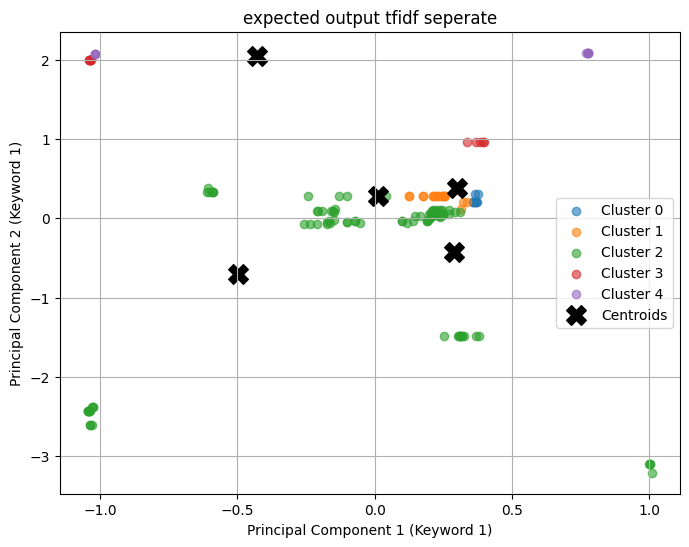

In [85]:
# Visualize clusters
plt.figure(figsize=(8, 6))
for i in range(k):
    plt.scatter(k_tfidf_sep[k_tfidf_sep['cluster'] == i]['PC1'], 
                k_tfidf_sep[k_tfidf_sep['cluster'] == i]['PC2'], 
                label=f'Cluster {i}', alpha=0.6)
plt.scatter(centroids_tfidf[:, 0], centroids_tfidf[:, 1], marker='X', s=200, c='black', label='Centroids')
plt.title('expected output tfidf seperate')
plt.xlabel('Principal Component 1 (Keyword 1)')
plt.ylabel('Principal Component 2 (Keyword 1)')
plt.legend()
plt.grid()
plt.show()

### kmeans bow

In [86]:
bow_labels, bow_centroids , centro= kmeans(bow_pca_array)

k_bow_sep['cluster'] = bow_labels
k_bow_sep

,PC1,PC2,cluster
0,0.777807,2.090152,2
1,-0.209755,0.092165,3
2,-0.608017,0.384740,0
3,0.357954,0.204393,0
4,0.207561,0.098906,0
...,...,...,...
142,-0.211577,-0.070257,3
143,0.228590,0.043702,4
144,0.327357,-1.485883,1
145,0.213562,0.044713,4


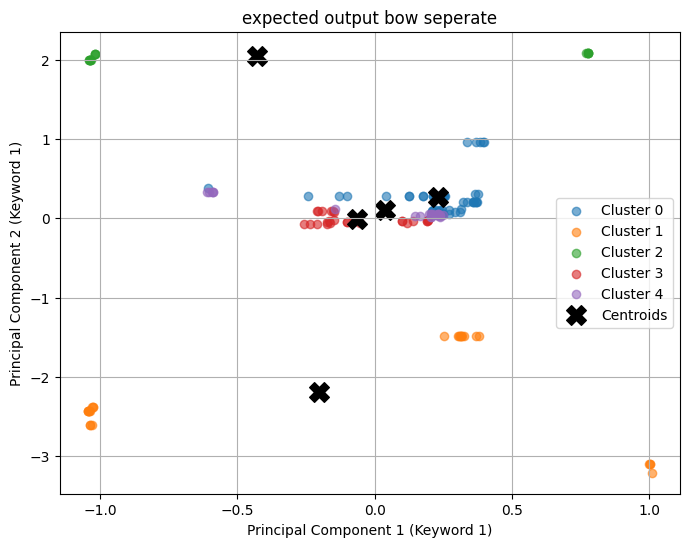

In [87]:
plt.figure(figsize=(8, 6))
for i in range(k):
    plt.scatter(k_bow_sep[k_bow_sep['cluster'] == i]['PC1'],
                k_bow_sep[k_bow_sep['cluster'] == i]['PC2'], label=f'Cluster {i}', alpha = 0.6)
plt.scatter(bow_centroids[:, 0], bow_centroids[:, 1], marker='X', s=200, c='black', label='Centroids')
plt.title('expected output bow seperate')
plt.xlabel('Principal Component 1 (Keyword 1)')
plt.ylabel('Principal Component 2 (Keyword 1)')
plt.legend()
plt.grid()
plt.show()

## silhoutte score 

In [88]:
silhouette_tfidf = silhouette_score(tfidf_pca_array, labels_tfidf)
print(f"Silhouette Score (TF seperate): {silhouette_tfidf:.2f}")
score_tf = silhouette_tfidf


Silhouette Score (TF seperate): -0.16


In [89]:
silhouette_bow = silhouette_score(bow_pca_array, bow_labels)
print(f"Silhouette Score (bow seperate): {silhouette_bow:.2f}")
score_bow = silhouette_bow

Silhouette Score (bow seperate): 0.31


# ANALYSIS

## cluster Analysis percentage

In [90]:
#for seperated keywords with tfidf
# Calculate the percentage distribution of genres in each cluster
tfidf_test = k_tfidf_sep.copy()
tfidf_test["genre"] = data["genre"]
cluster_genre_distribution = tfidf_test.groupby(['cluster','genre']).size().unstack(fill_value=0)

# Normalize the distribution to percentages
tfidf_sep_truth = cluster_genre_distribution.div(cluster_genre_distribution.sum(axis=1), axis=0) * 100

# Display the genre distribution in each cluster
tfidf_sep_truth

genre,classical,country,hip-hop,pop,rock
cluster,,,,,
0,0.000000,0.000000,50.000000,0.000000,50.000000
1,0.000000,27.777778,22.222222,22.222222,27.777778
2,14.851485,23.762376,21.782178,23.762376,15.841584
3,75.000000,0.000000,0.000000,25.000000,0.000000
4,37.500000,0.000000,0.000000,0.000000,62.500000


In [91]:
# for seperated keywords with bow
bow_test = k_bow_sep.copy()
bow_test["genre"] = data["genre"]
cluster_genre_distribution = bow_test.groupby(['cluster', 'genre']).size().unstack(fill_value=0)

# Normalize the distribution to percentages
bow_sep_truth = cluster_genre_distribution.div(cluster_genre_distribution.sum(axis=1), axis=0) * 100

# Display the genre distribution in each cluster
bow_sep_truth


genre,classical,country,hip-hop,pop,rock
cluster,,,,,
0,9.259259,24.074074,22.222222,20.370370,24.074074
1,23.076923,0.000000,19.230769,57.692308,0.000000
2,66.666667,0.000000,0.000000,0.000000,33.333333
3,18.518519,18.518519,29.629630,0.000000,33.333333
4,4.000000,44.000000,20.000000,20.000000,12.000000


In [92]:
percent = [tfidf_sep_truth, bow_sep_truth]
if len(tfidf_sep_truth)== 4 and len(bow_sep_truth) == 4:
    multi_index = pd.MultiIndex.from_tuples([
        ('TF-IDF Seperate', '0'), ('TF-IDF Seperate', '1'), ('TF-IDF Seperate', '2'), ('TF-IDF Seperate', '3'),
        ('BoW Seperate', '0'), ('BoW Seperate', '1'), ('BoW Seperate', '2'), ('BoW Seperate', '3'),
    ], names=['name', 'cluster'])

    percent_truth = pd.concat(percent)
    percent_truth.index = multi_index
    print(percent_truth)

## pca testing using ground truth analysis

In [93]:
# ground truth column addition to the data 
true_clusters = np.zeros(len(data))

unique_genre = (data['genre']).unique()

for i,word in enumerate(data["genre"]):
    single=word.split()
    for genre in single:
        if genre == unique_genre[0]:
            true_clusters[i] = 0
        elif genre == unique_genre[1]:
            true_clusters[i] = 1
        elif genre == unique_genre[2]:
            true_clusters[i] = 2
        elif genre == unique_genre[3]:
            true_clusters[i] = 3
        elif genre == unique_genre[4]:
            true_clusters[i] = 4
            
data['true_clusters'] = true_clusters
data

,song_id,keyword_1,keyword_2,keyword_3,genre,true_clusters
0,74,guitar,happy,distorted,rock,0.0
1,103,brass,energetic,melodic,classical,1.0
2,201,banjo,happy,acoustic,country,2.0
3,194,synth,energetic,heavy,hip-hop,3.0
4,184,synth,energetic,slow,hip-hop,3.0
...,...,...,...,...,...,...
142,195,synth,angry,melodic,hip-hop,3.0
143,7,guitar,energetic,fast,pop,4.0
144,14,guitar,happy,rhythmic,pop,4.0
145,36,synth,mellow,danceable,pop,4.0


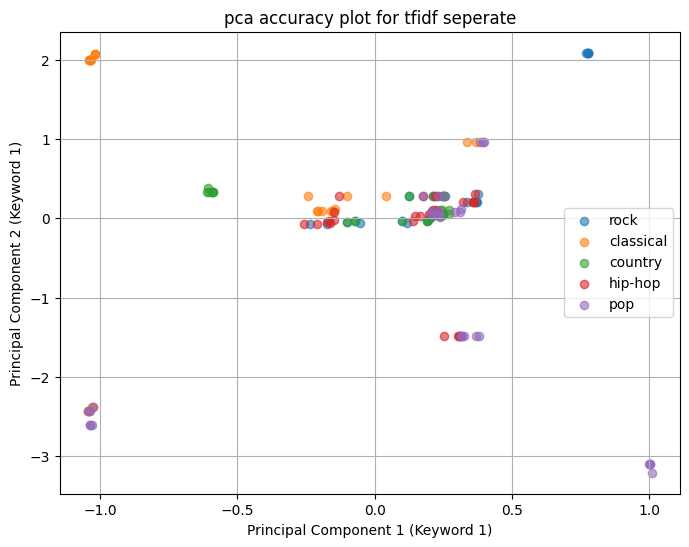

In [94]:
plt.figure(figsize=(8, 6))
for i in range(5):
    plt.scatter(k_tfidf_sep[data['true_clusters'] == i]['PC1'], 
                k_tfidf_sep[data['true_clusters'] == i]['PC2'],
                label= unique_genre[i], alpha=0.6)
#plt.scatter(centroids_bow_all[:, 0], centroids_bow_all[:, 1], marker='X', s=200, c='black', label='Centroids')
plt.title('pca accuracy plot for tfidf seperate')
plt.xlabel('Principal Component 1 (Keyword 1)')
plt.ylabel('Principal Component 2 (Keyword 1)')
plt.legend()
plt.grid()
plt.show()

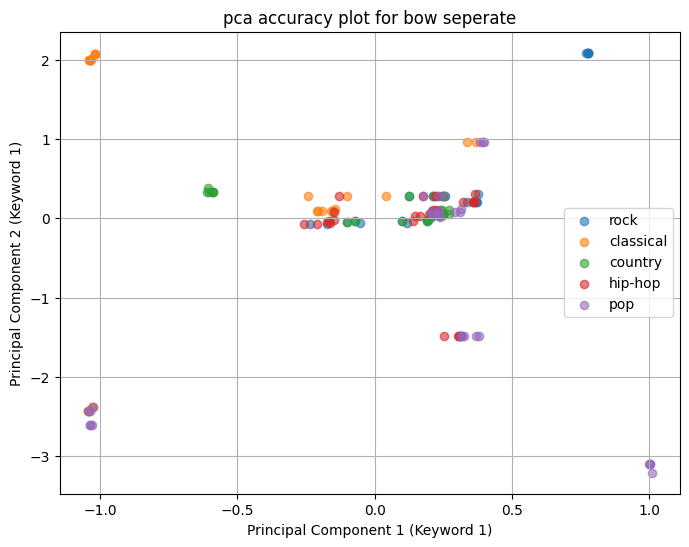

In [95]:
plt.figure(figsize=(8, 6))
for i in range(5):
    plt.scatter(k_bow_sep[data['true_clusters'] == i]['PC1'], 
                k_bow_sep[data['true_clusters'] == i]['PC2'],
                label= unique_genre[i], alpha=0.6)
#plt.scatter(centroids_bow_all[:, 0], centroids_bow_all[:, 1], marker='X', s=200, c='black', label='Centroids')
plt.title('pca accuracy plot for bow seperate')
plt.xlabel('Principal Component 1 (Keyword 1)')
plt.ylabel('Principal Component 2 (Keyword 1)')
plt.legend()
plt.grid()
plt.show()

## Application of the machine learning algo

In [96]:
def weight(kw_inp, word_column ,data = data.copy()):
        kw_weightage = np.zeros(len(data))
        for i,word in enumerate(word_column):
            single =word.split()
            for keyword in single:
                if keyword == kw_inp:
                    kw_weightage[i] += 1
        return kw_weightage

def weightage(kw1_inp,kw2_inp,kw3_inp,data1=data.copy()):
        kw1_weightage = weight(kw1_inp,data1['keyword_1'])
        kw2_weightage = weight(kw2_inp,data1['keyword_2'])
        kw3_weightage = weight(kw3_inp,data1['keyword_3'])
        weightage =((kw1_weightage) + (kw2_weightage) + (kw3_weightage))
        return weightage

def genre_predictor(weightage,soham,data1=data.copy()):
        pc1_expected = 0
        pc2_expected = 0
        data1['weightage'] = weightage
        for i, value in enumerate(soham['PC1']*data1['weightage']):
                pc1_expected +=value
        pc1_expected = pc1_expected/len(data1)
        for i , value in enumerate(soham['PC2']*data1['weightage']):
                pc2_expected +=value
        pc2_expected = pc2_expected/len(data1)
        combine = {
              'PC1': [pc1_expected],
              'PC2': [pc2_expected]}
        combine_df = pd.DataFrame(combine)
        soham = pd.concat([soham, combine_df], ignore_index=True)
        labels =kmeans(soham.to_numpy())[0]
        soham['cluster'] = labels
        
        return soham['cluster'][147]

In [97]:
def accuracy(data1 = data.copy()):
    correct = 0
    for i in range(len(data1)):
        weightage1 = weightage(data1['keyword_1'][i],data1['keyword_2'][i],data1['keyword_3'][i])
        prediction = genre_predictor(weightage1,k_tfidf_sep)
        row = tfidf_sep_truth.loc[prediction]
        max_per = max(row)
        max_percent_ind = [i for i, som1 in enumerate(row) if som1 == max_per]
        expected = []
        for index in max_percent_ind:
            expected.append(bank[index])
        for word in expected:
            if word == data1['genre'][i]:
                correct += 1

    return correct/len(data1)*100

In [98]:
kw1_inp = 'guitar' #input("enter 1st keyword")
kw2_inp = 'happy'  #input("enter 2nd keyword")
kw3_inp = 'upbeat'  #input("enter 3rd keyword")

bank = ['classical', 'country', 'hip-hop', 'pop', 'rock']
#answer = country

scores=[score_tf,score_bow]
max_score = max(scores)
print(f'max_score = {max_score}')
if max_score == score_tf:
    soham = pd.DataFrame(tfidf_pca_array, columns=['PC1', 'PC2'])
    results = genre_predictor(weightage(kw1_inp,kw2_inp,kw3_inp),soham)
    print(f'TF-IDF,Cluster = {results}')
    row = tfidf_sep_truth.loc[results]
    print(row)
    max_per = max(row)
    max_percent_ind = [i for i, som1 in enumerate(row) if som1 == max_per]
    expected = []
    for index in max_percent_ind:
        expected.append(bank[index])
    print(f"Expected Genres: {expected}")


if max_score == score_bow :
    soham = pd.DataFrame(bow_pca_array, columns=['PC1', 'PC2'])
    results = genre_predictor(weightage(kw1_inp,kw2_inp,kw3_inp),soham)
    print(f'BoW,Cluster = {results}')
    row = bow_sep_truth.loc[results]
    print(row)
    max_per = max(row)
    max_percent_ind = [i for i, som1 in enumerate(row) if som1 == max_per]
    expected = []
    for index in max_percent_ind:
        expected.append(bank[index])
    print(f"Expected Genres: {expected}")

max_score = 0.31282005575307503
BoW,Cluster = 3
genre
classical    18.518519
country      18.518519
hip-hop      29.629630
pop           0.000000
rock         33.333333
Name: 3, dtype: float64
Expected Genres: ['rock']


In [99]:
accuracy()

C:\Users\agarw\AppData\Local\Temp\ipykernel_46244\836203618.py:8: RuntimeWarning: Mean of empty slice.
  new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
c:\Users\agarw\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\agarw\AppData\Local\Temp\ipykernel_46244\836203618.py:8: RuntimeWarning: Mean of empty slice.
  new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
c:\Users\agarw\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\agarw\AppData\Local\Temp\ipykernel_46244\836203618.py:8: RuntimeWarning: Mean of empty slice.
  new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
c:\Users\agarw\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:1

40.816326530612244

In [100]:
print(centro)

[[ 0.23559987  0.09772095]
 [ 0.3058054  -1.48906552]
 [-1.01887416  2.07218305]
 [ 0.18912997 -0.03801047]
 [ 0.20635613  0.01341837]]


## dataframes /required visual attachments for reports 

In [101]:
cov_array_kw1 = np.cov(standardize_data(tfidf_kw1), rowvar=False)
pd.DataFrame(cov_array_kw1,columns = unique_kw1,index=unique_kw1)

,guitar,brass,banjo,synth,violin,piano
guitar,1.006849,-0.254942,-0.184918,-0.576410,-0.242189,-0.267262
brass,-0.254942,1.006849,-0.059069,-0.184123,-0.077363,-0.085372
banjo,-0.184918,-0.059069,1.006849,-0.133551,-0.056114,-0.061923
synth,-0.576410,-0.184123,-0.133551,1.006849,-0.174913,-0.193022
violin,-0.242189,-0.077363,-0.056114,-0.174913,1.006849,-0.081101
piano,-0.267262,-0.085372,-0.061923,-0.193022,-0.081101,1.006849


In [102]:
eigenvalues, eigenvectors = np.linalg.eig(cov_array_kw1)
eigenvalues

array([-8.88178420e-16,  1.60047918e+00,  1.20986813e+00,  1.05466186e+00,
        1.08343320e+00,  1.09265352e+00])

In [103]:
pd.DataFrame(eigenvectors)

,0,1,2,3,4,5
0,-0.593454,-0.755961,-0.274497,0.026789,-0.011433,0.011776
1,-0.314405,0.096405,0.429169,0.190953,-0.543022,-0.613460
2,-0.236433,0.065026,0.236291,-0.937434,0.056648,-0.045241
3,-0.543593,0.629543,-0.553161,0.039396,-0.017537,0.018331
4,-0.300873,0.090184,0.382697,0.237514,0.809768,-0.206755
5,-0.327175,0.102680,0.481859,0.161469,-0.213905,0.760524


In [104]:
pd.DataFrame(pca_1,columns = ["PC1","PC2"])

,PC1,PC2
0,0.298860,0.065916
1,0.033330,0.118943
2,-0.721616,0.390744
3,0.270539,0.070045
4,0.270539,0.070045
...,...,...
142,0.270539,0.070045
143,0.298860,0.065916
144,0.298860,0.065916
145,0.270539,0.070045


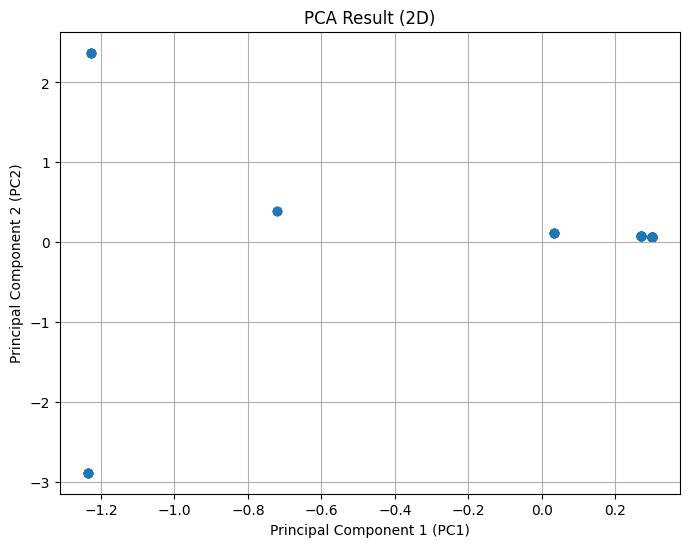

In [105]:
sample = pd.DataFrame(pca_1,columns = ["PC1","PC2"])
plt.figure(figsize=(8, 6))
plt.scatter(sample['PC1'], sample['PC2'], alpha=0.5)
plt.title('PCA Result (2D)')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.grid()
plt.show()